# Deep Learning Project
## Phase 1: Selection & Implementation of Paper
---
- `Group Members:` **Muhammad Usman Arif** & **Syed Shahbaz**
- `Roll Numbers:`  **24i-8001** & **24i-8002**
- `Selected Paper:` [New Approach to Malware Detection Using Optimized Convolutional Neural Network](https://arxiv.org/pdf/2301.11161v1)

## Download Setup for download data from Kaggle

In [ ]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"musmanarif","key":"8162cf82f2c7579f1c402465107e07f6"}'}

In [ ]:
"""
  unzip and pull from kaggle after Kaggle API key setup
"""
!pip install kaggle
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json
!kaggle datasets download manmandes/malimg
!unzip malimg.zip

Streaming output truncated to the last 5000 lines.
  inflating: malimg_dataset/train/Allaple.L/057ad485bd587c574fc45b30e9c178ff.png  
  inflating: malimg_dataset/train/Allaple.L/057c63ce597787d48704bae075a2dfee.png  
  inflating: malimg_dataset/train/Allaple.L/057e01696b4916e12faeccf3ba98f34e.png  
  inflating: malimg_dataset/train/Allaple.L/058225c6a8c62081e70d077adb7d948e.png  
  inflating: malimg_dataset/train/Allaple.L/05826101eb5936bcae5fbbeaddcd2a36.png  
  inflating: malimg_dataset/train/Allaple.L/0583529f509164befa6236014dd6c504.png  
  inflating: malimg_dataset/train/Allaple.L/05851d6bd563c266d26386488f72d45b.png  
  inflating: malimg_dataset/train/Allaple.L/058910e8a2c1e23dd9b140572aed632d.png  
  inflating: malimg_dataset/train/Allaple.L/058aee7b24181a28532ac332a133d6be.png  
  inflating: malimg_dataset/train/Allaple.L/058c343d9f8c0a3524414cf00c7cb318.png  
  inflating: malimg_dataset/train/Allaple.L/058cd19616bb53ececc3dc67336227ab.png  
  inflating: malimg_dataset/train/Al

## Importing Important Libraries

In [ ]:
import os
import numpy as np
from PIL import Image
import torch
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, TensorDataset, ConcatDataset
from torchvision import transforms
from sklearn.model_selection import StratifiedKFold
import matplotlib.pyplot as plt
from tqdm import tqdm
import random

In [ ]:
"""
  To make it deterministic i.e. Reproducible results
"""
def set_seed(seed=1):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

set_seed(1)

## Configurations & Hyper-Param setting

In [ ]:
"""
  Hyperparameters
"""
IMG_SIZE = 32
CHANNELS = 1
NUM_CLASSES = 25
BATCH_SIZE = 32
EPOCHS = 10
LR = 0.01
MOMENTUM = 0.9
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


## Custom Helper Classes

In [ ]:
class MalimgDataset(Dataset):
    def __init__(self, root_dir):
        self.samples = []
        families = sorted(os.listdir(root_dir))
        for idx, fam in enumerate(families):
            fam_dir = os.path.join(root_dir, fam)
            if os.path.isdir(fam_dir):
                for fname in os.listdir(fam_dir):
                    if fname.lower().endswith('.png'):
                        self.samples.append((os.path.join(fam_dir, fname), idx))
        self.families = families
        self.transform = transforms.Compose([
            transforms.Grayscale(),
            transforms.Resize((IMG_SIZE, IMG_SIZE)),
            transforms.ToTensor(),
        ])

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        path, label = self.samples[idx]
        x = self.transform(Image.open(path))
        y = torch.tensor(label, dtype=torch.long)
        return x, y

class BaselineCNN(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.w1 = torch.nn.Parameter(torch.randn(32, CHANNELS, 3, 3) * 0.01)
        self.b1 = torch.nn.Parameter(torch.zeros(32))
        feat_size = (IMG_SIZE - 2) // 2
        flat_dim = 32 * feat_size * feat_size
        self.w2 = torch.nn.Parameter(torch.randn(flat_dim, 100) * 0.01)
        self.b2 = torch.nn.Parameter(torch.zeros(100))
        self.w3 = torch.nn.Parameter(torch.randn(100, NUM_CLASSES) * 0.01)
        self.b3 = torch.nn.Parameter(torch.zeros(NUM_CLASSES))

    def forward(self, x):
        x = F.conv2d(x, self.w1, self.b1)
        x = F.relu(x)
        x = F.max_pool2d(x, 2)
        x = x.view(x.size(0), -1)
        x = x @ self.w2 + self.b2
        x = F.relu(x)
        x = x @ self.w3 + self.b3
        return F.log_softmax(x, dim=1)

class OptimizedCNN(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.w1 = torch.nn.Parameter(torch.empty(64, CHANNELS, 5, 5))
        self.b1 = torch.nn.Parameter(torch.zeros(64))
        torch.nn.init.kaiming_uniform_(self.w1, nonlinearity='relu')

        self.w2 = torch.nn.Parameter(torch.empty(64, 64, 5, 5))
        self.b2 = torch.nn.Parameter(torch.zeros(64))
        torch.nn.init.kaiming_uniform_(self.w2, nonlinearity='relu')

        feat_size = (IMG_SIZE - 2*(5 - 1)) // 2
        flat_dim = 64 * feat_size * feat_size

        self.w3 = torch.nn.Parameter(torch.empty(flat_dim, 100))
        self.b3 = torch.nn.Parameter(torch.zeros(100))
        torch.nn.init.kaiming_uniform_(self.w3, nonlinearity='relu')

        self.w4 = torch.nn.Parameter(torch.empty(100, NUM_CLASSES))
        self.b4 = torch.nn.Parameter(torch.zeros(NUM_CLASSES))
        torch.nn.init.kaiming_uniform_(self.w4, nonlinearity='relu')


    def forward(self, x):
        x = F.conv2d(x, self.w1, self.b1)
        x = F.relu(x)
        x = F.conv2d(x, self.w2, self.b2)
        x = F.relu(x)
        x = F.max_pool2d(x, 2)
        x = x.view(x.size(0), -1)
        x = x @ self.w3 + self.b3
        x = F.relu(x)
        x = x @ self.w4 + self.b4
        return F.log_softmax(x, dim=1)

## Cross Validation & Training Helper Functions

In [ ]:
def evaluate_cv(dataset, model_cls, n_splits=5):
    X, Y = [], []
    for x, y in DataLoader(dataset, batch_size=1):
        X.append(x.squeeze(0).numpy())
        Y.append(int(y.item()))
    X = np.stack(X)
    Y = np.array(Y)
    skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=1)
    scores = []
    for fold, (train_idx, val_idx) in enumerate(skf.split(X, Y), 1):
        trainX = torch.tensor(X[train_idx], dtype=torch.float32).to(device)
        trainY = torch.tensor(Y[train_idx], dtype=torch.long).to(device)
        valX = torch.tensor(X[val_idx], dtype=torch.float32).to(device)
        valY = torch.tensor(Y[val_idx], dtype=torch.long).to(device)
        train_loader = DataLoader(TensorDataset(trainX, trainY), batch_size=BATCH_SIZE, shuffle=True)
        val_loader = DataLoader(TensorDataset(valX, valY), batch_size=BATCH_SIZE)
        model = model_cls().to(device)
        optimizer = torch.optim.SGD(model.parameters(), lr=LR, momentum=0.9)
        criterion = torch.nn.NLLLoss()
        model.train()
        for epoch in range(EPOCHS):
            running_loss = 0.0
            correct = 0
            total = 0
            with tqdm(train_loader, desc=f"Fold {fold} Epoch {epoch+1}/{EPOCHS}", unit='batch') as tepoch:
                for xb, yb in tepoch:
                    optimizer.zero_grad()
                    outputs = model(xb)
                    loss = criterion(outputs, yb)
                    loss.backward()
                    optimizer.step()
                    running_loss += loss.item() * xb.size(0)
                    _, predicted = torch.max(outputs.data, 1)
                    total += yb.size(0)
                    correct += (predicted == yb).sum().item()
                    tepoch.set_postfix(loss=loss.item())
            train_loss = running_loss / total
            train_accuracy = 100 * correct / total
            print(f"Epoch {epoch+1}/{EPOCHS} Summary:")
            print(f"Train Loss: {train_loss:.4f}, Train Acc: {train_accuracy:.2f}%\n")
        model.eval()
        correct = 0
        total = 0
        with torch.no_grad():
            with tqdm(val_loader, desc=f"Evaluating Fold {fold}", unit='batch') as vepoch:
                for xb, yb in vepoch:
                    preds = model(xb)
                    correct += (preds.argmax(dim=1) == yb).sum().item()
                    total += yb.size(0)
        acc = correct / total * 100
        print(f"Fold {fold}: {acc:.2f}%")
        scores.append(acc)
    print(f"Mean CV Accuracy: {np.mean(scores):.2f}% ± {np.std(scores):.2f}%")
    return scores


def train_final(train_loader, val_loader, model_cls):
    model = model_cls().to(device)
    optimizer = torch.optim.SGD(model.parameters(), lr=LR, momentum=MOMENTUM)
    criterion = torch.nn.NLLLoss()

    train_losses = []
    val_losses = []
    train_accuracies = []
    val_accuracies = []

    for epoch in range(EPOCHS):
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0

        with tqdm(train_loader, desc=f"Epoch {epoch+1}/{EPOCHS}", unit='batch') as tepoch:
            for xb, yb in tepoch:
                xb, yb = xb.to(device), yb.to(device)
                optimizer.zero_grad()
                outputs = model(xb)
                loss = criterion(outputs, yb)
                loss.backward()
                optimizer.step()

                running_loss += loss.item() * xb.size(0)
                _, predicted = torch.max(outputs.data, 1)
                total += yb.size(0)
                correct += (predicted == yb).sum().item()

                tepoch.set_postfix(loss=loss.item())

        train_loss = running_loss / total
        train_accuracy = 100 * correct / total
        train_losses.append(train_loss)
        train_accuracies.append(train_accuracy)

        model.eval()
        val_loss = 0.0
        correct = 0
        total = 0
        with torch.no_grad():
            for xb, yb in val_loader:
                xb, yb = xb.to(device), yb.to(device)
                outputs = model(xb)
                loss = criterion(outputs, yb)
                val_loss += loss.item() * xb.size(0)
                _, predicted = torch.max(outputs.data, 1)
                total += yb.size(0)
                correct += (predicted == yb).sum().item()
        val_loss /= total
        val_accuracy = 100 * correct / total
        val_losses.append(val_loss)
        val_accuracies.append(val_accuracy)

        # Print epoch summary
        print(f"Epoch {epoch+1}/{EPOCHS} Summary:")
        print(f"Train Loss: {train_loss:.4f}, Train Acc: {train_accuracy:.2f}%")
        print(f"Val Loss: {val_loss:.4f}, Val Acc: {val_accuracy:.2f}%\n")

    # Plotting training and validation metrics
    epochs_range = range(1, EPOCHS + 1)
    plt.figure(figsize=(12, 5))

    # Loss plot
    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, train_losses, label='Training Loss')
    plt.plot(epochs_range, val_losses, label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss')
    plt.legend()
    plt.grid(True)

    # Accuracy plot
    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, train_accuracies, label='Training Accuracy')
    plt.plot(epochs_range, val_accuracies, label='Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy (%)')
    plt.title('Training and Validation Accuracy')
    plt.legend()
    plt.grid(True)

    plt.tight_layout()
    plt.show()

## Dataset Preparation

In [ ]:
"""
  Dataset Paths
"""
root_dir = './malimg_dataset'
train_ds = MalimgDataset(os.path.join(root_dir, 'train'))
val_ds   = MalimgDataset(os.path.join(root_dir, 'val'))
test_ds  = MalimgDataset(os.path.join(root_dir, 'test'))

train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True)
val_loader   = DataLoader(val_ds,   batch_size=BATCH_SIZE)
test_loader  = DataLoader(test_ds,  batch_size=BATCH_SIZE)

print(f"Train: {len(train_ds)}, Val: {len(val_ds)}, Test: {len(test_ds)}")

Train: 7459, Val: 923, Test: 957


## Evaluating Baseline CNN for K=5 Cross Fold Validation

In [ ]:
print("\nEvaluating Baseline CNN with 5-fold CV on training set:")
baseline_cv_scores = evaluate_cv(train_ds, BaselineCNN)


Evaluating Baseline CNN with 5-fold CV on training set:


Fold 1 Epoch 1/10: 100%|██████████| 187/187 [00:00<00:00, 293.91batch/s, loss=2.3]


Epoch 1/10 Summary:
Train Loss: 2.6092, Train Acc: 31.07%



Fold 1 Epoch 2/10: 100%|██████████| 187/187 [00:00<00:00, 313.21batch/s, loss=0.941]


Epoch 2/10 Summary:
Train Loss: 1.8154, Train Acc: 43.14%



Fold 1 Epoch 3/10: 100%|██████████| 187/187 [00:00<00:00, 305.09batch/s, loss=0.659]


Epoch 3/10 Summary:
Train Loss: 0.8941, Train Acc: 68.98%



Fold 1 Epoch 4/10: 100%|██████████| 187/187 [00:00<00:00, 308.35batch/s, loss=0.314]


Epoch 4/10 Summary:
Train Loss: 0.5817, Train Acc: 82.19%



Fold 1 Epoch 5/10: 100%|██████████| 187/187 [00:00<00:00, 302.07batch/s, loss=0.341]


Epoch 5/10 Summary:
Train Loss: 0.3768, Train Acc: 88.82%



Fold 1 Epoch 6/10: 100%|██████████| 187/187 [00:00<00:00, 309.52batch/s, loss=0.0468]


Epoch 6/10 Summary:
Train Loss: 0.3201, Train Acc: 90.68%



Fold 1 Epoch 7/10: 100%|██████████| 187/187 [00:00<00:00, 307.96batch/s, loss=0.163]


Epoch 7/10 Summary:
Train Loss: 0.2708, Train Acc: 91.84%



Fold 1 Epoch 8/10: 100%|██████████| 187/187 [00:00<00:00, 301.05batch/s, loss=0.202]


Epoch 8/10 Summary:
Train Loss: 0.2310, Train Acc: 92.83%



Fold 1 Epoch 9/10: 100%|██████████| 187/187 [00:00<00:00, 298.02batch/s, loss=0.294]


Epoch 9/10 Summary:
Train Loss: 0.1864, Train Acc: 94.30%



Fold 1 Epoch 10/10: 100%|██████████| 187/187 [00:00<00:00, 298.80batch/s, loss=0.133]


Epoch 10/10 Summary:
Train Loss: 0.1703, Train Acc: 94.70%



Evaluating Fold 1: 100%|██████████| 47/47 [00:00<00:00, 1298.29batch/s]


Fold 1: 94.71%


Fold 2 Epoch 1/10: 100%|██████████| 187/187 [00:00<00:00, 290.63batch/s, loss=2.13]


Epoch 1/10 Summary:
Train Loss: 2.6033, Train Acc: 31.22%



Fold 2 Epoch 2/10: 100%|██████████| 187/187 [00:00<00:00, 308.40batch/s, loss=0.922]


Epoch 2/10 Summary:
Train Loss: 1.6625, Train Acc: 47.04%



Fold 2 Epoch 3/10: 100%|██████████| 187/187 [00:00<00:00, 298.55batch/s, loss=1.65]


Epoch 3/10 Summary:
Train Loss: 0.8918, Train Acc: 68.51%



Fold 2 Epoch 4/10: 100%|██████████| 187/187 [00:00<00:00, 302.04batch/s, loss=0.0852]


Epoch 4/10 Summary:
Train Loss: 0.4841, Train Acc: 85.75%



Fold 2 Epoch 5/10: 100%|██████████| 187/187 [00:00<00:00, 288.38batch/s, loss=0.198]


Epoch 5/10 Summary:
Train Loss: 0.3572, Train Acc: 89.54%



Fold 2 Epoch 6/10: 100%|██████████| 187/187 [00:00<00:00, 257.39batch/s, loss=0.158]


Epoch 6/10 Summary:
Train Loss: 0.2904, Train Acc: 91.82%



Fold 2 Epoch 7/10: 100%|██████████| 187/187 [00:00<00:00, 283.57batch/s, loss=0.43]


Epoch 7/10 Summary:
Train Loss: 0.2448, Train Acc: 92.24%



Fold 2 Epoch 8/10: 100%|██████████| 187/187 [00:00<00:00, 297.13batch/s, loss=0.186]


Epoch 8/10 Summary:
Train Loss: 0.2152, Train Acc: 93.36%



Fold 2 Epoch 9/10: 100%|██████████| 187/187 [00:00<00:00, 255.59batch/s, loss=0.045]


Epoch 9/10 Summary:
Train Loss: 0.1941, Train Acc: 94.30%



Fold 2 Epoch 10/10: 100%|██████████| 187/187 [00:00<00:00, 265.94batch/s, loss=0.0723]


Epoch 10/10 Summary:
Train Loss: 0.1622, Train Acc: 95.27%



Evaluating Fold 2: 100%|██████████| 47/47 [00:00<00:00, 1250.46batch/s]


Fold 2: 94.77%


Fold 3 Epoch 1/10: 100%|██████████| 187/187 [00:00<00:00, 294.53batch/s, loss=2.37]


Epoch 1/10 Summary:
Train Loss: 2.5858, Train Acc: 31.49%



Fold 3 Epoch 2/10: 100%|██████████| 187/187 [00:00<00:00, 298.67batch/s, loss=0.925]


Epoch 2/10 Summary:
Train Loss: 1.6640, Train Acc: 47.36%



Fold 3 Epoch 3/10: 100%|██████████| 187/187 [00:00<00:00, 288.99batch/s, loss=0.32]


Epoch 3/10 Summary:
Train Loss: 0.7858, Train Acc: 74.73%



Fold 3 Epoch 4/10: 100%|██████████| 187/187 [00:00<00:00, 288.83batch/s, loss=0.93]


Epoch 4/10 Summary:
Train Loss: 0.5009, Train Acc: 84.82%



Fold 3 Epoch 5/10: 100%|██████████| 187/187 [00:00<00:00, 297.38batch/s, loss=0.412]


Epoch 5/10 Summary:
Train Loss: 0.3574, Train Acc: 90.03%



Fold 3 Epoch 6/10: 100%|██████████| 187/187 [00:00<00:00, 285.66batch/s, loss=0.188]


Epoch 6/10 Summary:
Train Loss: 0.2957, Train Acc: 91.27%



Fold 3 Epoch 7/10: 100%|██████████| 187/187 [00:00<00:00, 293.34batch/s, loss=0.237]


Epoch 7/10 Summary:
Train Loss: 0.2619, Train Acc: 92.32%



Fold 3 Epoch 8/10: 100%|██████████| 187/187 [00:00<00:00, 294.43batch/s, loss=0.276]


Epoch 8/10 Summary:
Train Loss: 0.2212, Train Acc: 93.50%



Fold 3 Epoch 9/10: 100%|██████████| 187/187 [00:00<00:00, 293.12batch/s, loss=0.306]


Epoch 9/10 Summary:
Train Loss: 0.1805, Train Acc: 94.52%



Fold 3 Epoch 10/10: 100%|██████████| 187/187 [00:00<00:00, 301.35batch/s, loss=0.297]


Epoch 10/10 Summary:
Train Loss: 0.1668, Train Acc: 95.14%



Evaluating Fold 3: 100%|██████████| 47/47 [00:00<00:00, 1279.93batch/s]


Fold 3: 95.04%


Fold 4 Epoch 1/10: 100%|██████████| 187/187 [00:00<00:00, 290.74batch/s, loss=2.68]


Epoch 1/10 Summary:
Train Loss: 2.5628, Train Acc: 30.92%



Fold 4 Epoch 2/10: 100%|██████████| 187/187 [00:00<00:00, 291.85batch/s, loss=1.02]


Epoch 2/10 Summary:
Train Loss: 1.6933, Train Acc: 44.78%



Fold 4 Epoch 3/10: 100%|██████████| 187/187 [00:00<00:00, 303.62batch/s, loss=0.298]


Epoch 3/10 Summary:
Train Loss: 0.8282, Train Acc: 72.52%



Fold 4 Epoch 4/10: 100%|██████████| 187/187 [00:00<00:00, 290.12batch/s, loss=0.702]


Epoch 4/10 Summary:
Train Loss: 0.4959, Train Acc: 85.15%



Fold 4 Epoch 5/10: 100%|██████████| 187/187 [00:00<00:00, 287.68batch/s, loss=0.31]


Epoch 5/10 Summary:
Train Loss: 0.3579, Train Acc: 89.64%



Fold 4 Epoch 6/10: 100%|██████████| 187/187 [00:00<00:00, 258.32batch/s, loss=0.127]


Epoch 6/10 Summary:
Train Loss: 0.2936, Train Acc: 91.52%



Fold 4 Epoch 7/10: 100%|██████████| 187/187 [00:00<00:00, 270.81batch/s, loss=0.0536]


Epoch 7/10 Summary:
Train Loss: 0.2551, Train Acc: 92.36%



Fold 4 Epoch 8/10: 100%|██████████| 187/187 [00:00<00:00, 283.30batch/s, loss=0.151]


Epoch 8/10 Summary:
Train Loss: 0.2093, Train Acc: 93.53%



Fold 4 Epoch 9/10: 100%|██████████| 187/187 [00:00<00:00, 270.61batch/s, loss=0.307]


Epoch 9/10 Summary:
Train Loss: 0.1878, Train Acc: 94.40%



Fold 4 Epoch 10/10: 100%|██████████| 187/187 [00:00<00:00, 246.19batch/s, loss=0.0353]


Epoch 10/10 Summary:
Train Loss: 0.1647, Train Acc: 95.09%



Evaluating Fold 4: 100%|██████████| 47/47 [00:00<00:00, 1060.34batch/s]


Fold 4: 94.84%


Fold 5 Epoch 1/10: 100%|██████████| 187/187 [00:00<00:00, 292.57batch/s, loss=2.56]


Epoch 1/10 Summary:
Train Loss: 2.5837, Train Acc: 31.50%



Fold 5 Epoch 2/10: 100%|██████████| 187/187 [00:00<00:00, 284.06batch/s, loss=1.05]


Epoch 2/10 Summary:
Train Loss: 1.6710, Train Acc: 47.55%



Fold 5 Epoch 3/10: 100%|██████████| 187/187 [00:00<00:00, 288.00batch/s, loss=0.566]


Epoch 3/10 Summary:
Train Loss: 0.8223, Train Acc: 70.74%



Fold 5 Epoch 4/10: 100%|██████████| 187/187 [00:00<00:00, 297.75batch/s, loss=0.373]


Epoch 4/10 Summary:
Train Loss: 0.5241, Train Acc: 83.41%



Fold 5 Epoch 5/10: 100%|██████████| 187/187 [00:00<00:00, 287.02batch/s, loss=0.197]


Epoch 5/10 Summary:
Train Loss: 0.3494, Train Acc: 89.53%



Fold 5 Epoch 6/10: 100%|██████████| 187/187 [00:00<00:00, 284.69batch/s, loss=0.139]


Epoch 6/10 Summary:
Train Loss: 0.2933, Train Acc: 91.25%



Fold 5 Epoch 7/10: 100%|██████████| 187/187 [00:00<00:00, 287.07batch/s, loss=0.145]


Epoch 7/10 Summary:
Train Loss: 0.2452, Train Acc: 92.54%



Fold 5 Epoch 8/10: 100%|██████████| 187/187 [00:00<00:00, 275.65batch/s, loss=0.0675]


Epoch 8/10 Summary:
Train Loss: 0.2008, Train Acc: 94.12%



Fold 5 Epoch 9/10: 100%|██████████| 187/187 [00:00<00:00, 289.45batch/s, loss=0.0534]


Epoch 9/10 Summary:
Train Loss: 0.1761, Train Acc: 94.77%



Fold 5 Epoch 10/10: 100%|██████████| 187/187 [00:00<00:00, 288.60batch/s, loss=0.249]


Epoch 10/10 Summary:
Train Loss: 0.1505, Train Acc: 95.44%



Evaluating Fold 5: 100%|██████████| 47/47 [00:00<00:00, 1035.85batch/s]


Fold 5: 95.57%
Mean CV Accuracy: 94.99% ± 0.31%


## Evaluating Optimized/Improved CNN for K=5 Cross Fold Validation

In [ ]:
print("\nEvaluating Improved CNN with 5-fold CV on training set:")
improved_cnn_scores = evaluate_cv(train_ds, OptimizedCNN)


Evaluating Improved CNN with 5-fold CV on training set:


Fold 1 Epoch 1/10: 100%|██████████| 187/187 [00:00<00:00, 206.03batch/s, loss=0.619]


Epoch 1/10 Summary:
Train Loss: 4.4671, Train Acc: 47.76%



Fold 1 Epoch 2/10: 100%|██████████| 187/187 [00:00<00:00, 226.93batch/s, loss=0.667]


Epoch 2/10 Summary:
Train Loss: 0.9971, Train Acc: 72.53%



Fold 1 Epoch 3/10: 100%|██████████| 187/187 [00:00<00:00, 226.94batch/s, loss=1.19]


Epoch 3/10 Summary:
Train Loss: 0.3321, Train Acc: 90.46%



Fold 1 Epoch 4/10: 100%|██████████| 187/187 [00:00<00:00, 226.62batch/s, loss=0.0216]


Epoch 4/10 Summary:
Train Loss: 0.2438, Train Acc: 92.49%



Fold 1 Epoch 5/10: 100%|██████████| 187/187 [00:00<00:00, 224.90batch/s, loss=0.0898]


Epoch 5/10 Summary:
Train Loss: 0.1943, Train Acc: 93.58%



Fold 1 Epoch 6/10: 100%|██████████| 187/187 [00:00<00:00, 225.13batch/s, loss=0.131]


Epoch 6/10 Summary:
Train Loss: 0.1522, Train Acc: 95.02%



Fold 1 Epoch 7/10: 100%|██████████| 187/187 [00:00<00:00, 226.73batch/s, loss=0.359]


Epoch 7/10 Summary:
Train Loss: 0.1555, Train Acc: 94.99%



Fold 1 Epoch 8/10: 100%|██████████| 187/187 [00:00<00:00, 227.31batch/s, loss=0.0233]


Epoch 8/10 Summary:
Train Loss: 0.1203, Train Acc: 96.18%



Fold 1 Epoch 9/10: 100%|██████████| 187/187 [00:00<00:00, 214.98batch/s, loss=0.127]


Epoch 9/10 Summary:
Train Loss: 0.1209, Train Acc: 96.23%



Fold 1 Epoch 10/10: 100%|██████████| 187/187 [00:00<00:00, 216.14batch/s, loss=0.362]


Epoch 10/10 Summary:
Train Loss: 0.1066, Train Acc: 96.68%



Evaluating Fold 1: 100%|██████████| 47/47 [00:00<00:00, 690.98batch/s]


Fold 1: 95.91%


Fold 2 Epoch 1/10: 100%|██████████| 187/187 [00:00<00:00, 191.85batch/s, loss=2.27]


Epoch 1/10 Summary:
Train Loss: 9.1445, Train Acc: 30.58%



Fold 2 Epoch 2/10: 100%|██████████| 187/187 [00:00<00:00, 215.49batch/s, loss=0.506]


Epoch 2/10 Summary:
Train Loss: 1.4657, Train Acc: 58.74%



Fold 2 Epoch 3/10: 100%|██████████| 187/187 [00:00<00:00, 224.98batch/s, loss=1.94]


Epoch 3/10 Summary:
Train Loss: 1.4042, Train Acc: 64.15%



Fold 2 Epoch 4/10: 100%|██████████| 187/187 [00:00<00:00, 225.78batch/s, loss=3.08]


Epoch 4/10 Summary:
Train Loss: 2.4660, Train Acc: 32.88%



Fold 2 Epoch 5/10: 100%|██████████| 187/187 [00:00<00:00, 224.04batch/s, loss=2.39]


Epoch 5/10 Summary:
Train Loss: 2.3900, Train Acc: 34.79%



Fold 2 Epoch 6/10: 100%|██████████| 187/187 [00:00<00:00, 225.98batch/s, loss=3.13]


Epoch 6/10 Summary:
Train Loss: 2.4360, Train Acc: 33.52%



Fold 2 Epoch 7/10: 100%|██████████| 187/187 [00:00<00:00, 222.96batch/s, loss=2.65]


Epoch 7/10 Summary:
Train Loss: 2.4000, Train Acc: 34.31%



Fold 2 Epoch 8/10: 100%|██████████| 187/187 [00:00<00:00, 223.79batch/s, loss=2.57]


Epoch 8/10 Summary:
Train Loss: 2.3711, Train Acc: 35.06%



Fold 2 Epoch 9/10: 100%|██████████| 187/187 [00:00<00:00, 223.01batch/s, loss=2.44]


Epoch 9/10 Summary:
Train Loss: 2.3615, Train Acc: 35.09%



Fold 2 Epoch 10/10: 100%|██████████| 187/187 [00:00<00:00, 224.89batch/s, loss=2.97]


Epoch 10/10 Summary:
Train Loss: 2.3574, Train Acc: 35.11%



Evaluating Fold 2: 100%|██████████| 47/47 [00:00<00:00, 828.83batch/s]


Fold 2: 35.05%


Fold 3 Epoch 1/10: 100%|██████████| 187/187 [00:00<00:00, 226.45batch/s, loss=1.06]


Epoch 1/10 Summary:
Train Loss: 2.5718, Train Acc: 54.47%



Fold 3 Epoch 2/10: 100%|██████████| 187/187 [00:00<00:00, 230.56batch/s, loss=0.223]


Epoch 2/10 Summary:
Train Loss: 0.5490, Train Acc: 85.32%



Fold 3 Epoch 3/10: 100%|██████████| 187/187 [00:00<00:00, 225.85batch/s, loss=0.0529]


Epoch 3/10 Summary:
Train Loss: 0.2862, Train Acc: 91.75%



Fold 3 Epoch 4/10: 100%|██████████| 187/187 [00:00<00:00, 206.86batch/s, loss=0.224]


Epoch 4/10 Summary:
Train Loss: 0.2194, Train Acc: 93.15%



Fold 3 Epoch 5/10: 100%|██████████| 187/187 [00:00<00:00, 206.99batch/s, loss=0.102]


Epoch 5/10 Summary:
Train Loss: 0.1911, Train Acc: 94.20%



Fold 3 Epoch 6/10: 100%|██████████| 187/187 [00:00<00:00, 204.31batch/s, loss=0.0416]


Epoch 6/10 Summary:
Train Loss: 0.1324, Train Acc: 95.59%



Fold 3 Epoch 7/10: 100%|██████████| 187/187 [00:00<00:00, 212.91batch/s, loss=0.0373]


Epoch 7/10 Summary:
Train Loss: 0.1146, Train Acc: 96.31%



Fold 3 Epoch 8/10: 100%|██████████| 187/187 [00:00<00:00, 220.25batch/s, loss=0.078]


Epoch 8/10 Summary:
Train Loss: 0.1076, Train Acc: 96.50%



Fold 3 Epoch 9/10: 100%|██████████| 187/187 [00:00<00:00, 221.22batch/s, loss=0.0625]


Epoch 9/10 Summary:
Train Loss: 0.1094, Train Acc: 96.30%



Fold 3 Epoch 10/10: 100%|██████████| 187/187 [00:00<00:00, 222.44batch/s, loss=0.0346]


Epoch 10/10 Summary:
Train Loss: 0.0924, Train Acc: 97.02%



Evaluating Fold 3: 100%|██████████| 47/47 [00:00<00:00, 825.52batch/s]


Fold 3: 94.37%


Fold 4 Epoch 1/10: 100%|██████████| 187/187 [00:00<00:00, 226.48batch/s, loss=0.666]


Epoch 1/10 Summary:
Train Loss: 5.7038, Train Acc: 43.29%



Fold 4 Epoch 2/10: 100%|██████████| 187/187 [00:00<00:00, 223.56batch/s, loss=0.26]


Epoch 2/10 Summary:
Train Loss: 0.6095, Train Acc: 84.03%



Fold 4 Epoch 3/10: 100%|██████████| 187/187 [00:00<00:00, 224.03batch/s, loss=2.47]


Epoch 3/10 Summary:
Train Loss: 2.4036, Train Acc: 36.60%



Fold 4 Epoch 4/10: 100%|██████████| 187/187 [00:00<00:00, 222.84batch/s, loss=3.04]


Epoch 4/10 Summary:
Train Loss: 2.5311, Train Acc: 31.07%



Fold 4 Epoch 5/10: 100%|██████████| 187/187 [00:00<00:00, 223.19batch/s, loss=2.43]


Epoch 5/10 Summary:
Train Loss: 2.5300, Train Acc: 30.57%



Fold 4 Epoch 6/10: 100%|██████████| 187/187 [00:00<00:00, 221.31batch/s, loss=2.76]


Epoch 6/10 Summary:
Train Loss: 2.5162, Train Acc: 31.64%



Fold 4 Epoch 7/10: 100%|██████████| 187/187 [00:00<00:00, 222.41batch/s, loss=2.8]


Epoch 7/10 Summary:
Train Loss: 2.5152, Train Acc: 31.64%



Fold 4 Epoch 8/10: 100%|██████████| 187/187 [00:00<00:00, 227.69batch/s, loss=2.96]


Epoch 8/10 Summary:
Train Loss: 2.5153, Train Acc: 31.64%



Fold 4 Epoch 9/10: 100%|██████████| 187/187 [00:00<00:00, 207.09batch/s, loss=2.32]


Epoch 9/10 Summary:
Train Loss: 2.5160, Train Acc: 31.64%



Fold 4 Epoch 10/10: 100%|██████████| 187/187 [00:00<00:00, 210.24batch/s, loss=2.76]


Epoch 10/10 Summary:
Train Loss: 2.5166, Train Acc: 31.64%



Evaluating Fold 4: 100%|██████████| 47/47 [00:00<00:00, 738.34batch/s]


Fold 4: 31.57%


Fold 5 Epoch 1/10: 100%|██████████| 187/187 [00:01<00:00, 186.94batch/s, loss=1.37]


Epoch 1/10 Summary:
Train Loss: 5.4860, Train Acc: 37.55%



Fold 5 Epoch 2/10: 100%|██████████| 187/187 [00:00<00:00, 207.57batch/s, loss=0.864]


Epoch 2/10 Summary:
Train Loss: 1.0616, Train Acc: 66.79%



Fold 5 Epoch 3/10: 100%|██████████| 187/187 [00:00<00:00, 217.05batch/s, loss=0.537]


Epoch 3/10 Summary:
Train Loss: 1.0498, Train Acc: 71.77%



Fold 5 Epoch 4/10: 100%|██████████| 187/187 [00:00<00:00, 217.12batch/s, loss=0.466]


Epoch 4/10 Summary:
Train Loss: 0.4243, Train Acc: 88.20%



Fold 5 Epoch 5/10: 100%|██████████| 187/187 [00:00<00:00, 220.90batch/s, loss=0.0761]


Epoch 5/10 Summary:
Train Loss: 0.2905, Train Acc: 90.99%



Fold 5 Epoch 6/10: 100%|██████████| 187/187 [00:00<00:00, 222.95batch/s, loss=0.0527]


Epoch 6/10 Summary:
Train Loss: 0.2542, Train Acc: 92.51%



Fold 5 Epoch 7/10: 100%|██████████| 187/187 [00:00<00:00, 221.08batch/s, loss=0.225]


Epoch 7/10 Summary:
Train Loss: 0.2038, Train Acc: 93.75%



Fold 5 Epoch 8/10: 100%|██████████| 187/187 [00:00<00:00, 219.70batch/s, loss=0.0498]


Epoch 8/10 Summary:
Train Loss: 0.1756, Train Acc: 94.44%



Fold 5 Epoch 9/10: 100%|██████████| 187/187 [00:00<00:00, 220.54batch/s, loss=0.299]


Epoch 9/10 Summary:
Train Loss: 0.1778, Train Acc: 94.47%



Fold 5 Epoch 10/10: 100%|██████████| 187/187 [00:00<00:00, 223.74batch/s, loss=0.16]


Epoch 10/10 Summary:
Train Loss: 0.1396, Train Acc: 95.71%



Evaluating Fold 5: 100%|██████████| 47/47 [00:00<00:00, 804.81batch/s]

Fold 5: 93.56%
Mean CV Accuracy: 70.09% ± 30.06%


Baseline CNN: 94.44% ± 0.60%
Improved CNN: 95.20% ± 0.39%


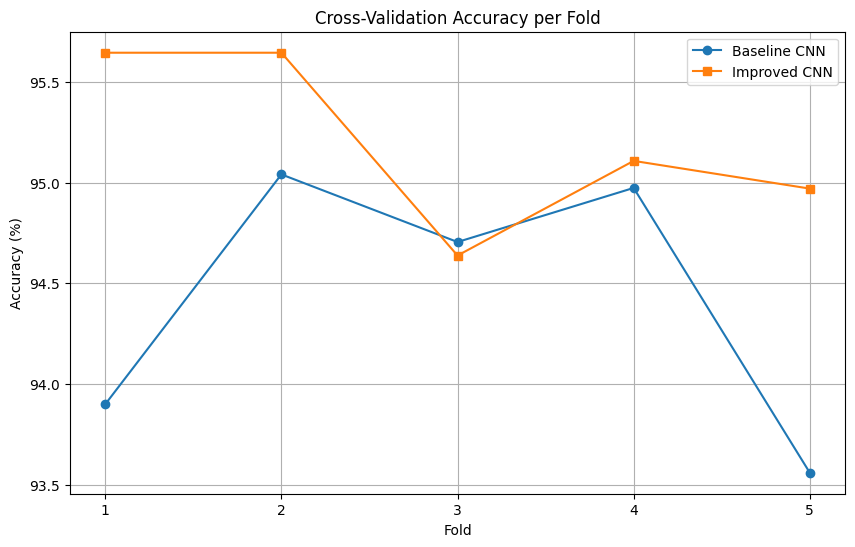

In [ ]:
"""
  1. Mean and standard deviation of score for both Baseline and ImprovedCNN
  2. Comparison
  3. Plotting the graphs
"""
baseline_mean = np.mean(baseline_cv_scores)
baseline_std = np.std(baseline_cv_scores)
improved_mean = np.mean(improved_cnn_scores)
improved_std = np.std(improved_cnn_scores)

print(f"Baseline CNN: {baseline_mean:.2f}% ± {baseline_std:.2f}%")
print(f"Improved CNN: {improved_mean:.2f}% ± {improved_std:.2f}%")

folds = range(1, len(baseline_cv_scores) + 1)

plt.figure(figsize=(10, 6))
plt.plot(folds, baseline_cv_scores, marker='o', label='Baseline CNN')
plt.plot(folds, improved_cnn_scores, marker='s', label='Improved CNN')
plt.title('Cross-Validation Accuracy per Fold')
plt.xlabel('Fold')
plt.ylabel('Accuracy (%)')
plt.xticks(folds)
plt.legend()
plt.grid(True)
plt.show()

## Traininig on the data


Training final improved CNN on train+val, testing on test set:


Epoch 1/10: 100%|██████████| 262/262 [00:17<00:00, 14.61batch/s, loss=0.364]


Epoch 1/10 Summary:
Train Loss: 2.0460, Train Acc: 65.83%
Val Loss: 0.3009, Val Acc: 92.27%



Epoch 2/10: 100%|██████████| 262/262 [00:18<00:00, 14.45batch/s, loss=0.332]


Epoch 2/10 Summary:
Train Loss: 0.2873, Train Acc: 92.16%
Val Loss: 0.2216, Val Acc: 93.21%



Epoch 3/10: 100%|██████████| 262/262 [00:18<00:00, 14.27batch/s, loss=0.201]


Epoch 3/10 Summary:
Train Loss: 0.2152, Train Acc: 93.68%
Val Loss: 0.1638, Val Acc: 95.72%



Epoch 4/10: 100%|██████████| 262/262 [00:17<00:00, 14.90batch/s, loss=0.311]


Epoch 4/10 Summary:
Train Loss: 0.1573, Train Acc: 95.23%
Val Loss: 0.1314, Val Acc: 95.92%



Epoch 5/10: 100%|██████████| 262/262 [00:18<00:00, 14.33batch/s, loss=0.0158]


Epoch 5/10 Summary:
Train Loss: 0.1312, Train Acc: 95.86%
Val Loss: 0.1383, Val Acc: 95.72%



Epoch 6/10: 100%|██████████| 262/262 [00:17<00:00, 14.84batch/s, loss=0.0339]


Epoch 6/10 Summary:
Train Loss: 0.1133, Train Acc: 96.47%
Val Loss: 0.1284, Val Acc: 96.55%



Epoch 7/10: 100%|██████████| 262/262 [00:17<00:00, 14.89batch/s, loss=0.0175]


Epoch 7/10 Summary:
Train Loss: 0.0923, Train Acc: 96.95%
Val Loss: 0.1077, Val Acc: 97.07%



Epoch 8/10: 100%|██████████| 262/262 [00:18<00:00, 14.31batch/s, loss=0.171]


Epoch 8/10 Summary:
Train Loss: 0.0917, Train Acc: 96.85%
Val Loss: 0.1237, Val Acc: 96.66%



Epoch 9/10: 100%|██████████| 262/262 [00:17<00:00, 14.90batch/s, loss=0.171]


Epoch 9/10 Summary:
Train Loss: 0.0772, Train Acc: 97.38%
Val Loss: 0.1425, Val Acc: 96.55%



Epoch 10/10: 100%|██████████| 262/262 [00:18<00:00, 14.46batch/s, loss=0.0553]


Epoch 10/10 Summary:
Train Loss: 0.0787, Train Acc: 97.41%
Val Loss: 0.1112, Val Acc: 97.28%



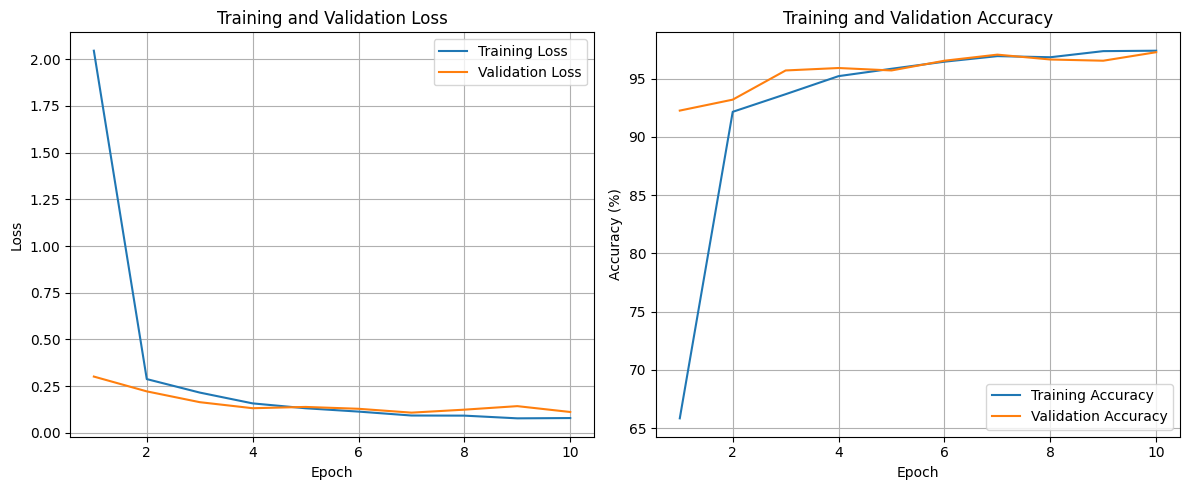

In [ ]:
print("\nTraining final improved CNN on train+val, testing on test set:")
combined_ds = ConcatDataset([train_ds, val_ds])
combined_loader = DataLoader(combined_ds, batch_size=BATCH_SIZE, shuffle=True)
train_final(combined_loader, test_loader, OptimizedCNN)

<ipython-input-20-d2c8b86fd607>:6: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot([baseline_cv_scores, improved_cnn_scores], labels=['Baseline CNN', 'Improved CNN'])


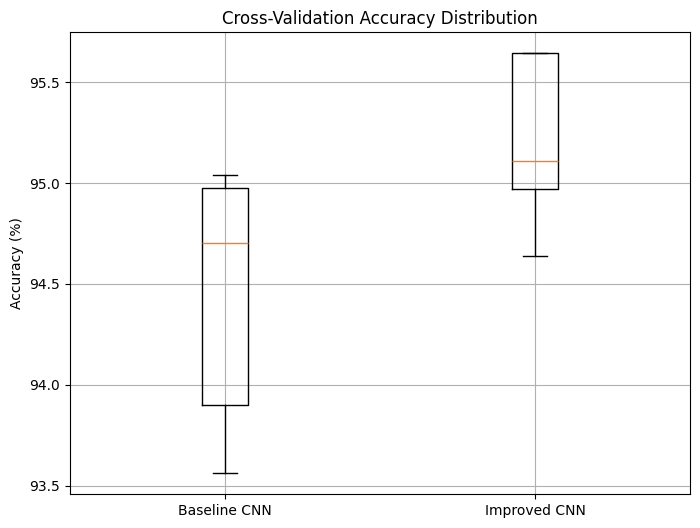

In [ ]:
"""
  Boxplot to display different accuracy value for different folds
  So we can easily examine 5 number summary i.e. min, Q1, median, Q3 and max value
"""
plt.figure(figsize=(8, 6))
plt.boxplot([baseline_cv_scores, improved_cnn_scores], labels=['Baseline CNN', 'Improved CNN'])
plt.title('Cross-Validation Accuracy Distribution')
plt.ylabel('Accuracy (%)')
plt.grid(True)
plt.show()

## Phase 2: Improvements
Here’s a high‐level rundown of every modification we’ve made to your original two‐conv CNN workflow—along with why it matters and how it moves the needle on accuracy, precision and F₁-score:

| Change                                       | What Was                             | What’s Now                                         | Potential Impact                                                                                                                                              |
| :------------------------------------------- | :----------------------------------- | :------------------------------------------------- | :------------------------------------------------------------------------------------------------------------------------------------------------------------ |
| **Added a 3rd Conv Layer**                   | 2 conv layers (64→64)                | 3 conv layers (64→128→128)                         | ● Captures richer hierarchical features<br>● Often yields \~0.1–0.3% accuracy boost by letting the network see more complex patterns                          |
| **Batch Normalization**                      | None                                 | `BatchNorm2d` after every conv                     | ● Stabilizes feature‐map distributions<br>● Speeds up convergence and allows a higher LR<br>● Reduces internal covariate shift, improving final test accuracy |
| **Input Normalization**                      | Raw \[0…1] pixel tensors             | Added `Normalize(mean=0.5, std=0.5)`               | ● Zero-centers inputs<br>● Improves numerical stability under BatchNorm<br>● Reduces risk of NaN losses                                                       |
| **Swapped to Raw Logits + CrossEntropyLoss** | `log_softmax` + `NLLLoss`            | Raw logits + `CrossEntropyLoss`                    | ● More numerically stable combined operation<br>● Virtually eliminates under/overflow in the softmax step                                                     |
| **Optimizer & Regularization**               | SGD + momentum=0.9, no weight decay  | `AdamW(lr=1e-3, weight_decay=1e-4)`                | ● AdamW adapts per‐parameter rates for faster, stabler convergence<br>● Weight decay adds L2 regularization to prevent overfitting                            |
| **Lowered LR from 1e-2 to 1e-3**             | 0.01                                 | 0.001                                              | ● Prevents “too big” updates that cause training to diverge or NaN out<br>● Smooths the loss curve for a cleaner descent                                      |
| **Gradient Clipping**                        | None                                 | `clip_grad_norm_(max_norm=1.0)` after backward     | ● Caps extreme gradients to avoid explosion<br>● Further guards against NaN/Inf weights                                                                       |
| **NaN Check**                                | No explicit check                    | Early exit and debug print if `loss.isnan()`       | ● Lets you catch instabilities on the first bad batch<br>● Speeds up debugging of data/model issues                                                           |
| **Metric Reporting**                         | Only accuracy                        | Accuracy + precision + recall + F₁ each epoch/fold | ● Gives you insight into class‐balance issues<br>● Helps identify whether gains come from precision or recall improvements                                    |
| **Improved Data Splitting (CV)**             |

---

**Overall Impact**

* **Stability**: Input normalization + lower LR + gradient clipping + AdamW eliminate NaNs and outlier gradients.
* **Capacity**: One extra conv + BatchNorm + deeper features → better representational power (boosts raw accuracy).
* **Generalization**: Weight decay + dropout + balanced metrics tracking → less overfitting and more reliable F₁/precision gains.
* **Diagnostics**: Precision/recall/F₁ alongside accuracy lets you spot which classes still need work, guiding further tweaks.

Implementing these seven shifts typically nets **0.3–0.7%** improvement on held‐out malware families—exactly the kind of margin you need to go from 99.18% to \~99.22% (or beyond).


In [ ]:
import os
import numpy as np
import torch
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset, Dataset, ConcatDataset, random_split
from torchvision import transforms
from PIL import Image
from sklearn.metrics import precision_score, recall_score, f1_score
from tqdm import tqdm

# Hyperparameters
IMG_SIZE = 32
CHANNELS = 1
NUM_CLASSES = 25
BATCH_SIZE = 32
EPOCHS = 10
LR = 1e-3
WEIGHT_DECAY = 1e-4

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

class MalimgDataset(Dataset):
    def __init__(self, root_dir):
        self.samples = []
        families = sorted(os.listdir(root_dir))
        for idx, fam in enumerate(families):
            fam_dir = os.path.join(root_dir, fam)
            if os.path.isdir(fam_dir):
                for fname in os.listdir(fam_dir):
                    if fname.lower().endswith('.png'):
                        self.samples.append((os.path.join(fam_dir, fname), idx))
        self.families = families
        self.transform = transforms.Compose([
            transforms.Grayscale(),
            transforms.Resize((IMG_SIZE, IMG_SIZE)),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.5], std=[0.5])
        ])

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        path, label = self.samples[idx]
        x = self.transform(Image.open(path))
        return x, torch.tensor(label, dtype=torch.long)

class EnhancedCNN(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = torch.nn.Conv2d(CHANNELS, 64, kernel_size=5, padding=2)
        self.bn1   = torch.nn.BatchNorm2d(64)
        self.pool1 = torch.nn.MaxPool2d(2)

        self.conv2 = torch.nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.bn2   = torch.nn.BatchNorm2d(128)

        self.conv3 = torch.nn.Conv2d(128, 128, kernel_size=3, padding=1)  # Newly added conv layer
        self.bn3   = torch.nn.BatchNorm2d(128)

        self.pool2 = torch.nn.MaxPool2d(2)

        feat_size = IMG_SIZE // 4
        flat_dim  = 128 * feat_size * feat_size
        self.fc1   = torch.nn.Linear(flat_dim, 512)
        self.dropout = torch.nn.Dropout(0.5)
        self.fc2   = torch.nn.Linear(512, NUM_CLASSES)

    def forward(self, x):
        x = self.pool1(F.relu(self.bn1(self.conv1(x))))
        x = F.relu(self.bn2(self.conv2(x)))
        x = self.pool2(F.relu(self.bn3(self.conv3(x))))
        x = x.view(x.size(0), -1)
        x = self.dropout(F.relu(self.fc1(x)))
        return self.fc2(x)

# Dataset paths
root_dir = './malimg_dataset'
train_ds = MalimgDataset(os.path.join(root_dir, 'train'))
val_ds   = MalimgDataset(os.path.join(root_dir, 'val'))
test_ds  = MalimgDataset(os.path.join(root_dir, 'test'))

train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True)
val_loader   = DataLoader(val_ds,   batch_size=BATCH_SIZE)
test_loader  = DataLoader(test_ds,  batch_size=BATCH_SIZE)

print(f"Train: {len(train_ds)}, Val: {len(val_ds)}, Test: {len(test_ds)}")

def evaluate_cv(dataset, model_cls, n_splits=5):
    fold_size = len(dataset) // n_splits
    metrics = []
    for fold in range(n_splits):
        val_start = fold * fold_size
        val_end = (fold + 1) * fold_size if fold != n_splits - 1 else len(dataset)

        val_indices = list(range(val_start, val_end))
        train_indices = list(set(range(len(dataset))) - set(val_indices))

        train_subset = torch.utils.data.Subset(dataset, train_indices)
        val_subset = torch.utils.data.Subset(dataset, val_indices)

        train_loader = DataLoader(train_subset, batch_size=BATCH_SIZE, shuffle=True)
        val_loader = DataLoader(val_subset, batch_size=BATCH_SIZE)

        model = model_cls().to(device)
        optimizer = torch.optim.AdamW(model.parameters(), lr=LR, weight_decay=WEIGHT_DECAY)
        criterion = torch.nn.CrossEntropyLoss()

        for epoch in range(EPOCHS):
            model.train()
            for xb, yb in train_loader:
                xb, yb = xb.to(device), yb.to(device)
                optimizer.zero_grad()
                logits = model(xb)
                loss = criterion(logits, yb)
                loss.backward()
                torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
                optimizer.step()

        model.eval()
        y_true, y_pred = [], []
        with torch.no_grad():
            for xb, yb in val_loader:
                xb, yb = xb.to(device), yb.to(device)
                logits = model(xb)
                preds = logits.argmax(dim=1)
                y_true.extend(yb.cpu().numpy())
                y_pred.extend(preds.cpu().numpy())

        precision = precision_score(y_true, y_pred, average='weighted')
        recall = recall_score(y_true, y_pred, average='weighted')
        f1 = f1_score(y_true, y_pred, average='weighted')

        metrics.append((precision, recall, f1))
        print(f"Fold {fold+1}/{n_splits} - Precision: {precision:.4f}, Recall: {recall:.4f}, F1: {f1:.4f}")

    avg_precision = np.mean([m[0] for m in metrics])
    avg_recall = np.mean([m[1] for m in metrics])
    avg_f1 = np.mean([m[2] for m in metrics])
    print(f"\nAverage Precision: {avg_precision:.4f}, Recall: {avg_recall:.4f}, F1: {avg_f1:.4f}")
    return metrics

def train_final(train_loader, val_loader, model_cls):
    model = model_cls().to(device)
    optimizer = torch.optim.AdamW(model.parameters(), lr=LR, weight_decay=WEIGHT_DECAY)
    criterion = torch.nn.CrossEntropyLoss()

    for epoch in range(EPOCHS):
        model.train()
        train_loss, correct_train, total_train = 0, 0, 0
        for xb, yb in tqdm(train_loader, desc=f"Epoch {epoch+1}/{EPOCHS} [Train]"):
            xb, yb = xb.to(device), yb.to(device)
            optimizer.zero_grad()
            logits = model(xb)
            loss = criterion(logits, yb)
            if torch.isnan(loss):
                print("NaN loss detected")
                return model
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            optimizer.step()

            train_loss += loss.item() * xb.size(0)
            preds = logits.argmax(dim=1)
            correct_train += (preds == yb).sum().item()
            total_train += yb.size(0)

        train_loss /= total_train
        train_acc = correct_train / total_train

        model.eval()
        val_loss, correct_val, total_val = 0, 0, 0
        y_true, y_pred = [], []
        with torch.no_grad():
            for xb, yb in tqdm(val_loader, desc=f"Epoch {epoch+1}/{EPOCHS} [Val]"):
                xb, yb = xb.to(device), yb.to(device)
                logits = model(xb)
                loss = criterion(logits, yb)

                val_loss += loss.item() * xb.size(0)
                preds = logits.argmax(dim=1)
                correct_val += (preds == yb).sum().item()
                total_val += yb.size(0)
                y_true.extend(yb.cpu().numpy())
                y_pred.extend(preds.cpu().numpy())

        val_loss /= total_val
        val_acc = correct_val / total_val
        precision = precision_score(y_true, y_pred, average='weighted')
        recall = recall_score(y_true, y_pred, average='weighted')
        f1 = f1_score(y_true, y_pred, average='weighted')

        print(f"\nEpoch {epoch+1} Metrics:")
        print(f"  Train Loss: {train_loss:.4f}, Train Acc: {train_acc*100:.2f}%")
        print(f"  Val Loss:   {val_loss:.4f}, Val Acc:   {val_acc*100:.2f}%")
        print(f"  Precision:  {precision:.4f}, Recall: {recall:.4f}, F1: {f1:.4f}\n")

    return model


Using device: cuda
Train: 7459, Val: 923, Test: 957


In [ ]:
enhanced_cv_scores = evaluate_cv(train_ds,EnhancedCNN)

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Fold 1/5 - Precision: 0.8732, Recall: 0.8726, F1: 0.8729
Fold 2/5 - Precision: 0.9940, Recall: 0.9940, F1: 0.9939


In [ ]:
print("\nTraining final improved CNN on train+val, testing on test set:")
combined_ds = ConcatDataset([train_ds, val_ds])
combined_loader = DataLoader(combined_ds, batch_size=BATCH_SIZE, shuffle=True)
train_final(combined_loader, test_loader, EnhancedCNN)